 # <font color="orange"> Astroinformatics </font>


## VICReg (Variance-Invariance-Covariance Regularization) Demonstration

<br></br>
**By Daniele Petrillo and Daniel Fynn**  
**For Professor Longo** 



## Outline 
- Download Datasets and EDA - Daniele
- Resnet Model - Daniel 
- Vicreg Model - Daniele
- Transfer Learning - Daniel
    - Experiment One
    - Experiment Two
- Results - Daniel

## Aim

- The aim of this project was the study and implentation of the **VICReg** technique for self-supervised learning. 
- We compare the performance of ResNet and VICReg on 100% of training data.
<br></br>
- A secondary aim was to impent in a pseudo fashion a self supervised exercise. 
- We compare VICReg 100%/100% (training / classification) with VICReg 80%/20% 

## Libraries

In [ ]:
# for torch implementation
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary 
from torch import Tensor
from torch import nn
from torchvision.transforms import InterpolationMode

# utils for image processing and display
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import ImageOps, ImageFilter

# for cloud storage
from google.colab import drive
drive.mount('/content/drive')

# Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",  module = "matplotlib\..*" )

# device configuration for agnostic programming
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/drive
cuda


# <font color="orange"> Dataset Download and EDA </font>



## CIFAR10 [1]
- Training 50,000 images
- Test 10,000 images
- Image Size: 32 x 32, colour images 
- 10 classes 
    - plane 
    - car
    - bird
    - cat 
    - deer 
    - dog 
    - frog 
    - horse 
    - ship 
    - truck


### Loading and transformation of images

- *batchsize* = 128 was chosen as it works operationally and also has a high likelihood of multiple images of each class

- Transforms library - performs transformation on the images according to the compose list, and is facilitated simply while creating the object after downloading using `torchvision.datasets.CIFAR10`

- The normalizing values are taken from the VICReg article [2]

In [ ]:
batchsize = 128 

transform = transforms.Compose( 
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:13<00:00, 12699670.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


 frog horse plane  bird


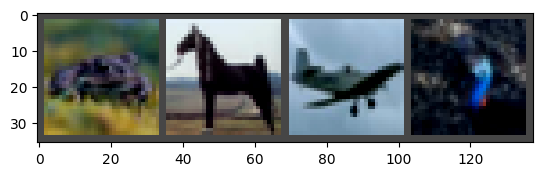

In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = npimg/np.amax(npimg)
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# <font color="orange"> ResNet Model </font> 

## Resnet 
- First developed by K. He, X. Zhang, S. Ren, S. Ren, J. Sun in 2015 for an Imagenet competition
- A type of deep **Convolutional Neural Network** (**CNN**) 
    - In the case of CNN, *convolution* is applied to the input data to filter the information and produce a **feature map**. This filter is also called a **kernel**, or feature detector, and its dimensions can be, for example, 3x3.
- Includes an additional residual features, a **skip connection**, to stop loss of information during iterations, which is common in deep learning models. 
- Also helps with the **Vanishing Gradient** problem.
- The skip connection is often used in Transformer models such as **BERT**, **ChatGPT**, etc.

<br></br>

<center><img src="res_buildingblock.png" alt="Drawing" style="width: 300px;"/>Figure 1: ResNet Building Block with Skip Connection [3]</center>

<br></br>

<center><img src="resnet_cifar.png" alt="Drawing" style="width: 600px;"/>Figure 2: ResNet Architecture for CIFAR10 [5]</center>



## Basic Block definition


#### The Basic Block [3] of any ResNet model is made up of:
- Convolution Layer
- Batch Normalisation
- RELU activation function 
- Convolution Layer
- Batch Normalisation 
- Identity (original input) - which is what makes it a recurrent network (by re-adding the identity after the previously listed layers) 
- Downsample - matches the size of the input with that of the output coming from the layers after convolution (which may change the overall dimension). 

#### Lambda Layer [7]
- a way to change the dimension the input for downsampling

In [ ]:
# building the basic block that constitutes all ResNet models
class BasicBlock(nn.Module):

  def __init__ (self, in_channels, out_channels, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)  # batchnorm has a bias value in its layer so it may cancel out 
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)
    return out

# class needed for modifying the forward pass on occasion
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)
    

## ResNet_CIFAR definition

### ResNet_CIFAR Class
- `nn.Module` is a parent object, from which **ResNet_CIFAR** will inherit all attributes and methods
- The structure of this ResNet variation was taken from [3], which was specific for CIFAR10, as there is issues with creating more channels and running out of dimensions to convolute. 
- `init()`: initializes the class, passing the required input parameters, in this case the number of layers is 18, classes is 10 to match CIFAR-10, image chanel is 3 for RGB, plus the block class is passed, which make up each layer of the resnet model. 
- `super()`: is to create an unique instance of the class
- `layers` list is the amount of basic blocks in the respective 3 super-layers
- `in_channels = 16` - defined as the input channels for the first basic block

- `_make_layer()`: creates the layers of the model, by adding blocks into a sequence and ensuring compatible tensor dimensionality 

- `forward()`: defines the ordering of the creation process, for the passing of the image endcodings, used for PyTorch


In [ ]:
# defining the whole ResNet as a sequence of basic blocks
class ResNet_CIFAR(nn.Module):
  '''
  img_channels: number of channels e.g. 3 for RGB, 1 for BW num layers: the amount of layers for the whole model
  num classes: 10 for cifar-10
  '''
  def __init__(self, block, img_channels=3, num_layers=18, num_classes=10):
    super(ResNet_CIFAR, self).__init__()
    layers = [2,2,2]                  # architecture of resnet 18 (how blocks are dispersed among layers)
    self.in_channels = 16             # named for being the input channels of the first basic block

    """ start of the first (initializing) section of ResNet """
    self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_channels, kernel_size=3, 
            stride=1, padding=1, bias=False) 
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    """ end of the first (initializing) section of ResNet """

    """ start of the sequence of basic blocks """
    self.layer1 = self._make_layer(block, 16, layers[0])
    self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
    #self.layer4 = self._make_layer(block, 128, layers[3], stride=2)           # needed for larger architectures
    """ end of the sequence of basic blocks """

    """ start of the classifier head """
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(64, num_classes) # this is removed when used as a backbone
    #self.sm = nn.Softmax()              # usually the softmax is included in the loss function
    """ end of the classifier head """

  # function to make the creation of basic blocks easier
  def _make_layer(self, block, out_channels, blocks, stride = 1) -> nn.Sequential:
    downsample = None
    # when the stride is more than one, the residual input has to be scaled down in order to avoid dimensional incompatibilities
    if stride != 1:
      downsample = LambdaLayer(lambda x:
                        F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, out_channels//4, out_channels//4), "constant", 0))
        
    layers = []
    layers.append(
        block(self.in_channels, out_channels, stride, downsample)
        )
      
    self.in_channels = out_channels

    for i in range(1, blocks):
          layers.append(
            block(self.in_channels, out_channels)
            )
    return nn.Sequential(*layers)


  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    #x = self.maxpool(x) not used because CIFAR10 is already low dimensional

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    #x = self.layer4(x)
    
    # The spatial dimension of the final layer's feature map should be (7, 7) for all ResNets.
    
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    #x = self.sm(x) # selfcontained in cross entropy loss function 
    return x


## Model Structure and Parameters:

In [ ]:
#instantiation of the ResNet_CIFAR class
model = ResNet_CIFAR(block=BasicBlock, img_channels=3, num_layers=18, num_classes=10)

# print of the architecture summary
print(model)
#summary(model, input_size = (3,32,32))


ResNet_CIFAR(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

## ResNet standard training

### Parameters 
- `num_epochs = 80` - fixed for all following experiments
- `learning_rate = 0.001`  - fixed for all following experiments
- `torch.manual_seed(5)`  - for reproduciability 

In [ ]:
num_epochs = 80        # chosen from origianl RESNET article [3]
learning_rate = 0.001  
torch.manual_seed(5)  # reproduciability 
   
model = ResNet_CIFAR(block=BasicBlock, img_channels=3, num_layers=18, num_classes=10).to(device) # moves the class to device (gpu)
loss = nn.CrossEntropyLoss()    # standard loss function for multiclass datasets
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam is the standard optimizer 
       

In [ ]:
start = time.time()

losses=[]

model.train() # pytorch functionality

for epoch in range(num_epochs):
  
  loss_vals = []
  
  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss_val = loss(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()      # aggregates the results of different epochs
    loss_val.backward()
    optimizer.step()

    loss_vals.append(loss_val.item())

  #print("Epoch", epoch, "loss:", sum(loss_vals)/len(trainloader))
  losses.append(sum(loss_vals)/len(trainloader))

print("Time to train model:", round((time.time() - start) / 60,2), "minutes" )
    

Time to train model: 23.14 minutes


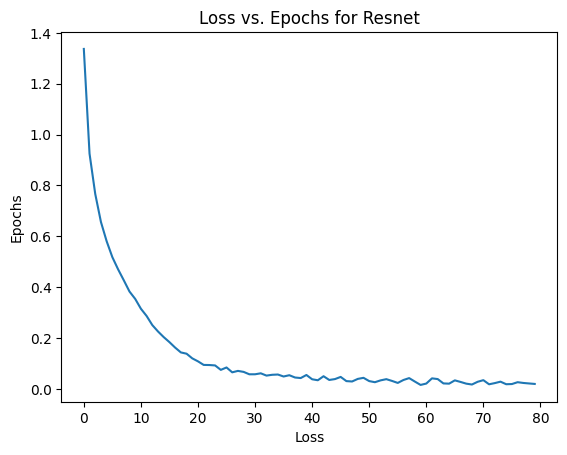

In [ ]:
# plots average loss over time
plt.plot(range(num_epochs), losses )
plt.ylabel("Epochs")
plt.xlabel("Loss")
plt.title("Loss vs. Epochs for Resnet")
plt.show()


### Training Set Accuracy

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the train images: {} %'.format(100 * correct / total))
    

Accuracy of the model on the train images: 99.616 %


### Test Set Accuracy

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    

Accuracy of the model on the test images: 80.57 %


# <font color="orange"> VicReg </font>

## VICReg Background

- **Self-Supervised Learning**
    - Most recent self-supervised methods aim to learn a substantial image representations by either producing global features (with invariance properties) or local features, respectively better suited for image classification and segmentation.
    - Almost all approaches rely on *joint embedding* architectures and a loss function that forces the learned features to be invariant to differences (often artificial) between two views of the same picture.
    - Something every method of this type suffers is the so called *collapsing problem*, that happens when the two architectures ignore the inputs and give identical constant output vectors.
    - Examples of self-supevised learning models:
        - VICReg
        - SimCLR
        - MoCoV2
        - BYOL
        - SimSiam
<br></br>
- **VICReg**
    - Similar to the above listed self supervised models, it utilises a siamese architecture. A **siamese architecture** simply has two parralel streams that take similar inputs and create similar embeddings. One of the main differences from the other techniques is the handling of these similarities and differences between the siamese networks. 
    - The main advantage of the VICReg approach is that it allows for not only different weights to be used on the two siamese networks, but also a whole different architecture, which can be useful for multi-modal approaches.  





## VICReg architecture

- Originally introduced [2] as a self supervised method for training siamese architectures based on the principle of preserving the information content of the embeddings through the use of a particular loss function.

- As visualized in Figure 3 below, the iter of a batch $I$ of $n$ input images is the following:

   1) Two batches of different views $X$ and $X'$ are produced using transformations sampled from a distribution $T$
   2) The two batches are encoded into representations $Y$ and $Y'$ through the use of a backbone (in our case a ResNet w/out the classifier head)
   3) The representations are then fed to an expander which creates embeddings $Z$ and $Z'$ of dimension $d$
   4) The total loss is calculated starting from these two batches of embeddings
   5) Finally the loss is backpropagated through some optimizer

<center>
    <img src="vicreg.png" alt="Drawing" style="width: 900px;"/>Figure 3: VICReg Architecture [2]</center>


## Loss definition

- Composed of three main terms, each responsible for a different type of regularization:
   1) **Variance**: preserves the variance of the embeddings, forcing the embedding vectors between a batch to be different (useful to fight the collapsing problem) 
   <br></br>
   $$
   v(Z) = {1\over d} \sum_{j=1}^d max(0, \gamma - S(z^j,\epsilon))
   $$
   <br></br>
   where $\gamma$ is a constant target value for the standard deviation, and $S$ is the regularized standard deviation:
   <br></br>
   $$
   S(x,\epsilon) = \sqrt{Var(x) + \epsilon}
   $$
   <br></br>
   2) **Invariance**: mathematically, it's the mean square distance between the embedding vectors, it grants the similarity of the two embeddings
   <br></br>
   $$
   s(Z,Z') = {1\over n} \sum_{i=1}^n \| z_i - z'_i \|^2_2
   $$
   <br></br>
   3) **Covariance**: decorrelates the different features of the embeddings
   <br></br>
   $$
   c(Z) = {1\over d} \sum_{i\neq j}[C(Z)]^2_{i,j}
   $$
   <br></br>
   where we define the covariance matrix $C(Z)$ as:
   <br></br>
   $$
   C(Z) = {1 \over n-1} \sum_{i=1}^n (z_i - \hat{z})(z_i - \hat{z})^T, \quad with \quad   \hat{z} = {1 \over n} \sum_{i=1}^n z_i
   $$

- The overall loss is a weighted average of the three terms:
<br></br>
$$
l(Z,Z') = \lambda s(Z,Z') + \mu [v(Z) + v(Z')] + \nu [c(Z) + c(Z')]
$$


## Transforms definition

### Image Transformations
- These transormations are taken from the VicReg Paper [3]:
    <br></br>
    - `RandomResizeCrop` - performs a random resizing of the image and then crops it, we have fixed the parameters beteen 0.4 and 0.9 for resizing, as CIFAR10 images are not very detailed. When using imagenet, it is possible to take a wider range of values. The `interplationModel` was taken from the github for VicReg[4]
    <br></br>
    - `Random horizontal flip` - takes a probabilty parameter that determines whether the image will flip horizontally 
    <br></br>
    - `Random apply` - applies randomly the `ColorJitter` using the parameters as outlined in the referenced article (80% of the time)
    <br></br>
    - `Random grayscale` - applies grayscale to the image at probability 20%
    <br></br>
    - `Gaussian blur` was used in the article but was ommitted for us, because CIFAR10 is quite blurry already. 
    <br></br>
    - `Solarization` - inverts the images around a threshold, different probabilities were used for the different views as this was done in the github for VicReg [4]
    <br></br>
    - The classes for gaussian blur and solarization are just to apply probability to applying the methods. 



In [ ]:
class TrainTransform(object):
  def __init__(self):
    
    self.transform = transforms.Compose(
        [transforms.RandomResizedCrop(32,scale=(0.4,0.9), interpolation=InterpolationMode.BICUBIC),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],p=0.8,),
         transforms.RandomGrayscale(p=0.2),
         #GaussianBlur(p=1.0),
         Solarization(p=0.0),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    self.transform_prime = transforms.Compose(
        [transforms.RandomResizedCrop(32,scale=(0.4,0.9), interpolation=InterpolationMode.BICUBIC),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],p=0.8,),
         transforms.RandomGrayscale(p=0.2),
         #GaussianBlur(p=1.0),
         Solarization(p=0.2),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

  def __call__(self,sample):
    x1 = self.transform(sample)
    x2 = self.transform_prime(sample)
    return x1, x2


class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            sigma = np.random.rand() * 1.9 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img

        
class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

## Dataset download and transform

In [ ]:
batchsize = 128
transform = TrainTransform()
 
trainset_siamese = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader_siamese = torch.utils.data.DataLoader(trainset_siamese, batch_size=batchsize,
                                        shuffle=True, num_workers=2)

testset_siamese = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader_siamese = torch.utils.data.DataLoader(testset_siamese, batch_size=batchsize,
                                       shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


 frog   car  bird plane


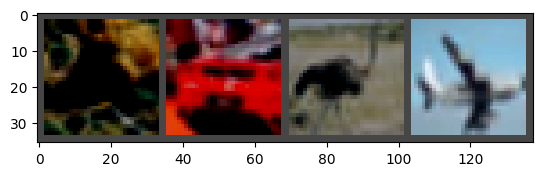

In [ ]:
# functions to show an image
dataiter = iter(trainloader_siamese)
images, labels = next(dataiter)

# show first crop of the input image + random transform
imshow(torchvision.utils.make_grid(images[0][0:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


 frog   car  bird plane


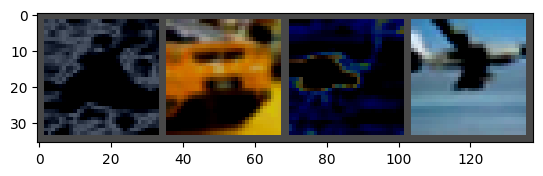

In [ ]:
# show second crop of the input image + random transform
imshow(torchvision.utils.make_grid(images[1][0:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## VicReg definition

### Some Utility Functions

In [ ]:
# projector builder function for VicReg global loss
def Projector(embedding, dimension):
  return nn.Sequential(
      nn.Linear(embedding,dimension), 
      nn.BatchNorm1d(dimension),
      nn.ReLU(True),
      nn.Linear(dimension,dimension), 
      nn.BatchNorm1d(dimension),
      nn.ReLU(True),
      nn.Linear(dimension,dimension, bias = False) # bias false as there is a quasi batch norm during the loss calculation  
  )

# useful later during loss calculation
def off_diagonal(x):
    """gets rid of the diagonal elements"""
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


### VicReg class

### VICReg Class

- `init()` just passes the batchsize paramater
- `super()` - again to create a unique instance of the class
- `self.embedding` - this is the final output dimension from the resnet model, so the inputs dimension to the projector
- `self.num_features` - amount of features projected to by the projector (aslo known as *expander*) [2,4] (4x embedding layer)
- `self.backbone.fc = nn.Identity()` changes the Resnet_CIFAR fully connected layer to identity to disable it during self supervised training. 
- `forward()` - naming important when using PyTorch, passes the image to the projector/expander and then calculates the loss funcation
- $\lambda$, $\mu$, $\nu$ = $[25,25,1]$ (from references [2],[4])


In [ ]:
class VICReg(nn.Module):
  
  def __init__(self,batchsize):
    super(VICReg, self).__init__()
    self.batchsize = batchsize
    self.embedding = 64
    self.num_features = 256
    self.backbone = ResNet_CIFAR(block=BasicBlock, img_channels=3, num_layers=18, num_classes=10)
    self.backbone.fc = nn.Identity() # at this stage we are doing unsupervised learning, so we don't need the classifier head
    self.projector = Projector(self.embedding, self.num_features)

  def forward(self, x, y):
    x = self.projector(self.backbone(x))  #View 1
    y = self.projector(self.backbone(y))  #View 2 

    repr_loss = F.mse_loss(x,y)
    
    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001) 
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    # we want the std_z>1, which implies that there is different embedding to the different images, 
    # if not there is contribution to the loss (which we want to minimise)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (torch.matmul(x.T, x)) / (self.batchsize - 1) # shape(embedding, embedding)
    cov_y = (torch.matmul(y.T, y)) / (self.batchsize - 1)
    # getting the off diagonal values and adding to the covariance part of the loss fn
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(self.num_features) 
    +off_diagonal(cov_y).pow_(2).sum().div(self.num_features)

    loss = (25 * repr_loss + 25 * std_loss+  1* cov_loss) # coefficient values taken from vicreg library[2,4]
    return loss


# <font color="orange">Transfer Learning </font>

## Transfer Learning 
- It's a problem in Machine Learning that aims to apply already trained models to new (often similar) tasks to those for which they were originally instructed
- First thought in 1976 by Bozinovski and Fulgos 
- Really useful for generalizing a model domain to a similar one
- Can significantly boost performance of models on tasks for which very few labeled data is available
- Applications vary from Natural Language Processing, Computer Vision, Computational Biology, Autonomous Driving Industry, etc.

### Typical Transfer Learning Workflow:

   1) Obtain a pre-trained model 
   2) Create a base model 
   3) Freeze all the layers 
   4) Add new trainable layers (e.g. a "classification head")
   5) Train only the new layers
   6) (optional) Fine tune all layers at low learning rate
   
<center>
    <img src="transferlearning.jpg" alt="Drawing" style="width: 600px;"/>Figure 4: Transfer Learning [6]</center>

# <font color="orange">Plan</font>

- **Experiment One** -  using 100% of the training data for both VICReg and classification head (with backbone weights/biases being fixed). To ensure the algorithm works and as the best case situation and control for the comparison with the second experiment.

- **Experiment Two** -  using 80% of the training data for VICReg, and the remaining 20% only for the classification head (with backbone weights/biases being fixed), to simulate self-supervised learning applications with significally less labeled data

# <font color="orange">Experiment One </font>


## Training

In [ ]:
start = time.time()

torch.manual_seed(5)
torch.backends.cudnn.benchmark = True # this checks multiple convolution algorithms at the start of running and takes the fastest
                                       

# initialize model
model = VICReg(batchsize)
model.to(device) # may get errors if the type of tensor isn't suitable for the cuda architecture
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # we chose Adam for simplicity

losses=[]

for epoch in range(num_epochs):

    loss_vals = []

    for i, ((x,y), labels) in enumerate(trainloader_siamese):
      x = x.to(device)
      y = y.to(device)

      loss = model.forward(x, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_vals.append(loss.item())
    #print("Epoch", epoch, "Total Loss:", sum(loss_vals)/len(trainloader_siamese))
    losses.append(sum(loss_vals)/len(trainloader_siamese))

print("Time to train model:", round((time.time() - start) / 60,2), "minutes" )


Time to train model: 127.07 minutes


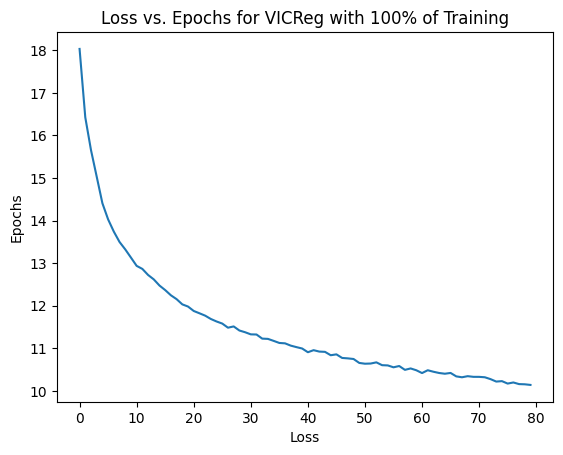

In [ ]:
# plots the average loss over time
plt.plot(range(num_epochs), losses )
plt.ylabel("Epochs")
plt.xlabel("Loss")
plt.title("Loss vs. Epochs for VICReg with 100% of Training")
plt.show()


In [ ]:
# saves the model parameters to drive for later use
torch.save(model.state_dict(), '/content/drive/MyDrive/model_vicreg_100')


## VicReg Loading

In [ ]:
# initialize an instance of the model in order to load its trained parameters from drive 
model = VICReg(batchsize)
model.load_state_dict(torch.load('/content/drive/MyDrive/model_vicreg_100')) 

# isolate the pretrained backbone from the VicReg model to use it as feature extractor for a ResNet architecture
model = model.backbone

# freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

# add a dense layer as classifier head (this will be the only part that now is trained)
model.fc = nn.Linear(64, 10)

# add model to device ("cpu" or "cuda" when available)
model.to(device)

# summary of the model
summary(model, input_size = (3,32,32)) #shows that param.requires_grad works to make only the classification head trainable.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

## Training of the classifier head

In [ ]:
start = time.time()
torch.manual_seed(5)

# define loss and optimizer
learning_rate = 0.001
num_epochs = 80  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()


losses = []
model.train()

for epoch in range(num_epochs):
  
  loss_vals = []
  
  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss_val = loss(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()      #aggregates the results of different epochs
    loss_val.backward()
    optimizer.step()

    loss_vals.append(loss_val.item())


  #print("Epoch", epoch, "loss:", sum(loss_vals)/len(trainloader))
  losses.append(sum(loss_vals)/len(trainloader))

print("Time to train model:", round((time.time() - start) / 60,2), "minutes" )


Time to train model: 19.68 minutes


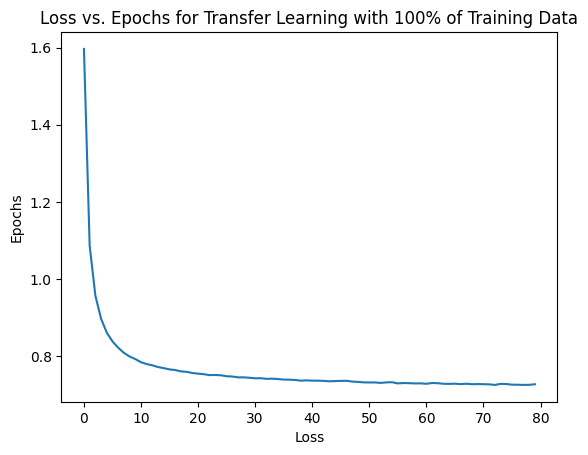

In [ ]:
# plotting the average loss over time
plt.plot(range(num_epochs), losses )
plt.ylabel("Epochs")
plt.xlabel("Loss")
plt.title("Loss vs. Epochs for Transfer Learning with 100% of Training Data")
plt.show()


### Train set accuracy

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the train images: {} %'.format(100 * correct / total))
    

Accuracy of the model on the train images: 74.638 %


### Test set accuracy

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    

Accuracy of the model on the test images: 74.49 %


# <font color="orange"> Experiment Two </font>


In [ ]:
start = time.time()

unlabelled = range(int(len(trainloader_siamese)*0.8)) # splits the dataset for the experiment

torch.manual_seed(5)
torch.backends.cudnn.benchmark = True

model = VICReg(batchsize)
model.to(device) # may get errors if the fype of tensor isnt suitable for the cuda archetucture
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(num_epochs):

    loss_vals = []

    for i, ((x,y), labels) in enumerate(trainloader_siamese):
      
      if i in unlabelled:   
        x = x.to(device)
        y = y.to(device)

        loss = model.forward(x, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_vals.append(loss.item())
    
    #print("Epoch", epoch, "Total Loss:", sum(loss_vals)/len(trainloader_siamese))
    losses.append(sum(loss_vals)/len(trainloader_siamese))

print("Time to train model:", round((time.time() - start) / 60,2), "minutes" )


Time to train model: 123.24 minutes


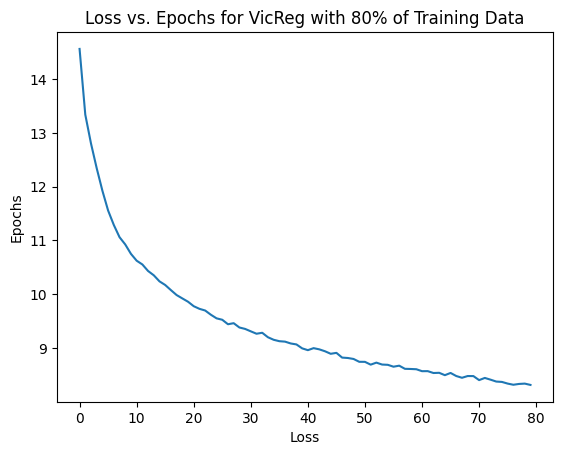

In [ ]:
# plots the average loss over time
plt.plot(range(num_epochs), losses )
plt.ylabel("Epochs")
plt.xlabel("Loss")
plt.title("Loss vs. Epochs for VicReg with 80% of Training Data")
plt.show()

In [ ]:
# saves the model paramenters to drive for later use
torch.save(model.state_dict(), '/content/drive/MyDrive/model_vicreg_80')


In [ ]:
# VicReg loading for feature extractor isolation
model = VICReg(batchsize)
model.load_state_dict(torch.load('/content/drive/MyDrive/model_vicreg_80')) 

model = model.backbone

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(64, 10)

model.to(device)


ResNet_CIFAR(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [ ]:
start = time.time()
torch.manual_seed(5)

# Define loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
model.train()

for epoch in range(num_epochs):
  
  loss_vals = []
  
  for i, (images, labels) in enumerate(trainloader):
    if i not in unlabelled:
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss_val = loss(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()      #aggregates the results of different epochs
      loss_val.backward()
      optimizer.step()

      loss_vals.append(loss_val.item())

  #print("Epoch", epoch, "loss:", sum(loss_vals)/len(trainloader))
  losses.append(sum(loss_vals)/len(trainloader))
print("Time to train model:", round((time.time() - start) / 60,2), "minutes" )


Time to train model: 17.55 minutes


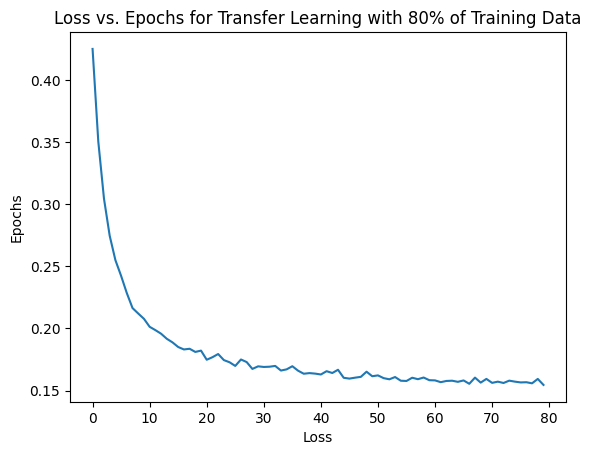

In [ ]:
# plots the average loss over time
plt.plot(range(num_epochs), losses )
plt.ylabel("Epochs")
plt.xlabel("Loss")
plt.title("Loss vs. Epochs for Transfer Learning with 80% of Training Data")
plt.show()

### Train set accuracy

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the train images: {} %'.format(100 * correct / total))
    

Accuracy of the model on the train images: 72.946 %


### Test set accuracy

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    

Accuracy of the model on the test images: 72.67 %


# <font color="orange"> Results </font>

<center>Table 1 - ResNet: CIFAR10 architecture, VICReg_100 (Experiment 1): model trained on 100% of training data for both pre-training and classifier head, VICReg_80 (Experiment 2) with respective 80/20 split.</center>

|<font size="+2">Model</font>|<font size="+2">Training Time (min)</font>|<font size="+2">Train Accuracy (%)</font>|<font size="+2">Test Accuracy (%)</font>|
|:-:|:-:|:-:|:-:|
|<font size="+2">ResNet</font>|<font size="+2">23.14</font>|<font size="+2">99.62</font>|<font size="+2">80.57</font>|
|<font size="+2">VICReg_100</font>|<font size="+2">127.07 + 19.68</font>|<font size="+2">74.64</font>|<font size="+2">74.49</font>|
|<font size="+2">VICReg_80</font>|<font size="+2">123.24 + 17.55</font>|<font size="+2">72.95</font>|<font size="+2">72.67</font>|

## Positives

- Overall we have found notable performances when using the VICReg approach, and it has successfully demonstrated its value
- Accuracy on the test set is comparable the traditional ResNet training performance
- Robust learning (accuracy on test and train set are similar, i.e. no overfitting)
- Excellent results from the implementation of self supervised learning simulating  a small labeled datasets, as there isn't large differences when using the whole data set

## Negatives
- Really long computing times (order of the hour) even with GPU
- Limited architecture and transformations due to CIFAR10 nature
- Non-optimized parameters
- Testing restricted by time/computational power limits

## Future Improvements

- Testing the applied methods again on larger datasets (e.g. ImageNet)
- Also try datasets of varying nature (including segmentation tasks) with VICRegL
- Add more transformations/better optimizer
- Attempt different ratios for the training dataset to find the minimum labelled data that give acceptable results
- Increase number of epochs, and impose a stopping condition
- Free the two networks of the siamese architecture from sharing the same weigths
- Test the suitability of the method for multi-modal inputs (very promising)

# References 
1) CIFAR-10 and CIFAR-100 datasets. (2017, April 08). Retrieved from https://www.cs.toronto.edu/~kriz/cifar.html
2) A. Bardes, J. Ponce, Y. LeCun, VICREG: Variance-Invariance-Covariance Regularization For Self-Supervised Learning, 2022, ICLR
3) K. He, X. Zhang, S. Ren, J. Sun, Deep Residual Learning for Image Recognition, 2015  
4) facebookresearch. (2023, May 06). vicreg. Retrieved from https://github.com/facebookresearch/vicreg
5) Ruiz, P. (2018). ResNets for CIFAR-10 - Towards Data Science. Medium. Retrieved from https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0
6) Bhavsar, P. (2021). An Ultimate Guide To Transfer Learning In NLP. TOPBOTS. Retrieved from https://www.topbots.com/transfer-learning-in-nlp
7) akamaster. (2023, June 13). pytorch_resnet_cifar10. Retrieved from https://github.com/akamaster/pytorch_resnet_cifar10